# **Homework 3**
Etienne GAUTHIER

# Question 1

The (LASSO) problem is equivalent to the following problem:

$$\text{(LASSO)'}: \left\{
    \begin{array}{ll}
        \underset{v,w}{\min} \frac{1}{2}\lVert v \rVert_2^2 + \lambda \lVert w \rVert_1 \\
        s.t. \  v = Xw-y
    \end{array}
\right.$$

We compute the dual of (LASSO)':
$\underset{\mu}{\sup} g(\mu)$ where
\begin{align}
g(\mu) &= \underset{v,w}{\inf} \frac{1}{2}\lVert v \rVert_2^2 + \lambda \lVert w \rVert_1 - \mu^T (Xw-y-v)\\
&= \underset{v}{\inf} \left( \frac{1}{2}\lVert v \rVert_2^2 + \mu^T v \right) + \underset{w}{\inf} \left( \lambda \lVert w \rVert_1 - \mu^TXw\right) + \mu^Ty
\end{align}
We can simplify both infimum as in homework 2 by using the conjugate: first we have 
\begin{align} \underset{v}{\inf} \left( \frac{1}{2}\lVert v \rVert_2^2 + \mu^T v \right) &= - \underset{v}{\sup} \left(- \frac{1}{2}\lVert v \rVert_2^2 - \mu^T v \right) \\ 
&= - \frac{1}{2}\lVert \mu \rVert_2^2 
\end{align}
and similarly we have
$$\underset{w}{\inf} \left( \lambda \lVert w \rVert_1 - \mu^TXw\right) = \left\{
    \begin{array}{ll}
        0 \ \ \text{ if } \ \ \lVert \frac{1}{\lambda}X^T\mu \rVert_\infty \le 1  \\
        - \infty \ \ \text{ otherwise}
    \end{array}
\right.$$

So finally the dual of (LASSO)' is:
$$\left\{
    \begin{array}{ll}
        \underset{\mu}{\sup} -\frac{1}{2}\lVert \mu \rVert_2^2 - \mu^Ty \\
        s.t. \  \lVert X^T\mu \rVert_\infty \le \lambda
    \end{array}
\right.$$
(after change of variables $\mu \rightarrow -\mu$). This problem can be solved by taking the opposite of the following QP problem:
$$(QP):
    \begin{cases}
        \underset{\mu}{\inf} \frac{1}{2}\mu^T\mu + \mu^Ty \\
        s.t. \  A X^T \mu \le b
    \end{cases}
$$
where $b = (\lambda,...,\lambda) \in \mathbb{R}^{2d}$ and $A = \left[
\begin{array}{c}
  I_d \\
  \hline
  -I_d
\end{array}
\right] $.

# Question 2

Note: in the Newton method, we will take the same tolerance $\varepsilon$ as in the barrier method.

In [402]:
import numpy as np
import matplotlib.pyplot as plt

In [403]:
# minimize g := t * f0 + phi using Newton method

def g(t,v,Q,p,d,b):
  phi = 0
  for i in range(d):
    phi += - np.log(-(np.matmul(A,v)-b)[i][0])
  return t*((np.matmul(np.matmul(np.transpose(v), Q),v))+np.matmul(np.transpose(p),v)) + phi

def centering_step(Q,p,A,b,t,v0,eps):
  '''
  output: sequence of variables iterates (vi)
  '''

  d = b.shape[0] #dimension
  iterates = [v0]

  # initialisation
  grad_g = t*(2*np.matmul(Q,v0) + p) - sum([np.transpose(A[i,:][np.newaxis])/(np.matmul(A[i],v0)-b[i]) for i in range(d)])
  hess_g = t*2*Q + sum([(np.matmul(np.transpose(A[i,:][np.newaxis]), A[i,:][np.newaxis]) )/((np.matmul(A[i],v0)-b[i])**2) for i in range(d)])
  inv = np.linalg.inv(hess_g)
  delta = - np.matmul(inv, grad_g)
  lamb = np.matmul(np.matmul(np.transpose(grad_g), inv), grad_g)
  v = v0

  while(lamb/2 > eps):
    #backtracking line search
    alpha = 20/100
    beta = beta = 80/100
    t_back = 1
    while g(t,v+t_back*delta,Q,p,d,b) > g(t,v,Q,p,d,b) + alpha*t_back*np.matmul(np.transpose(grad_g),delta) and max(np.matmul(A,v)-b)[0]<0: # last condition: avoid infinite log in M
      t_back = beta*t_back
    #update
    v = iterates[-1]+t_back*delta
    iterates.append(v)
    grad_g = t*(2*np.matmul(Q, v) + p) - sum([np.transpose(A[i,:][np.newaxis])/(np.matmul(A[i],v)-b[i]) for i in range(d)])
    hess_g = t*2*Q + sum([(np.matmul(np.transpose(A[i,:][np.newaxis]), A[i,:][np.newaxis]) )/((np.matmul(A[i],v)-b[i])**2) for i in range(d)])
    inv = np.linalg.inv(hess_g)
    delta = - np.matmul(inv, grad_g)
    lamb = np.matmul(np.matmul(np.transpose(grad_g), inv), grad_g)

  return iterates

In [404]:
def barr_method(Q,p,A,b,v0,eps):

  t = t0
  d = b.shape[0]

  iterates = [v0]

  while(d/t >= eps):
    v = centering_step(Q,p,A,b,t,v0,eps)[-1]
    t = mu * t
    iterates.append(v)

  return iterates

# Question 3

In [405]:
def qp(v,Q,p):
  return (np.matmul(np.matmul(np.transpose(v), Q),v)+np.matmul(np.transpose(p),v))[0][0]

In [414]:
#parameters
t0 = 0.1
lambd = 10
eps=10e-7
n = 50
dim = 35

X = np.random.rand(n,dim)
y = np.random.rand(n,1)
A = np.concatenate((np.identity(dim),-np.identity(dim)))
A = np.matmul(A, np.transpose(X))
b = lambd * np.ones((2*dim,1))
Q = 1/2 * np.identity(n)
p = y
v0 = np.zeros((n,1)) # v0 is strictly feasible

<ipython-input-403-53c207eacf10>:6: RuntimeWarning: invalid value encountered in log
  phi += - np.log(-(np.matmul(A,v)-b)[i][0])


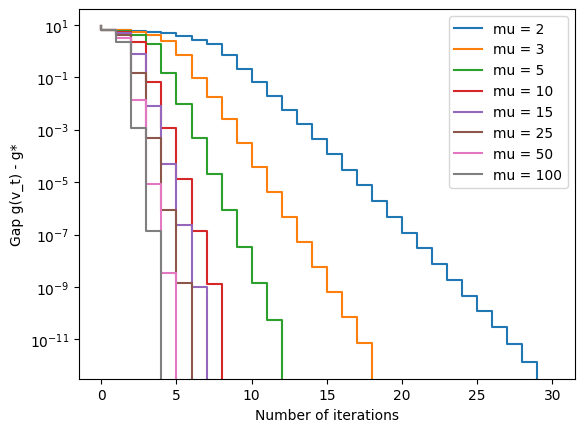

In [415]:
for mu in [2,3,5,10,15,25,50,100]:
  iterates = barr_method(Q,p,A,b,v0,eps)
  values = [qp(iterates[i],Q,p)-qp(iterates[-1],Q,p) for i in range(len(iterates))]
  plt.step(np.arange(len(iterates)), values, label=f'mu = {mu}')
plt.legend()
plt.ylabel("Gap g(v_t) - g*")
plt.xlabel("Number of iterations")
plt.semilogy()
plt.show()

-> linear in semilog scale

<ipython-input-403-53c207eacf10>:6: RuntimeWarning: invalid value encountered in log
  phi += - np.log(-(np.matmul(A,v)-b)[i][0])


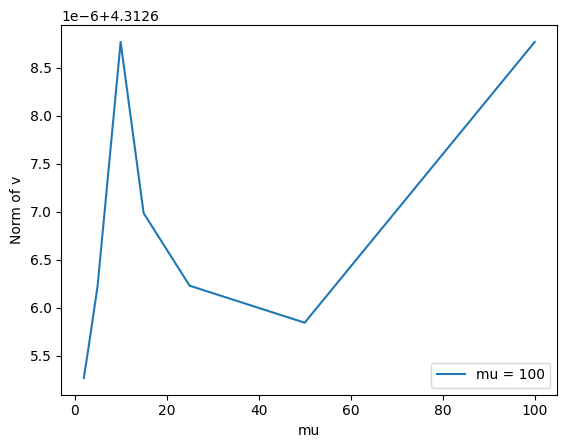

In [416]:
v_opt = []
for mu in [2,3,5,10,15,25,50,100]:
  iterates = barr_method(Q,p,A,b,v0,eps)
  v_opt.append(np.linalg.norm(iterates[-1]))
plt.plot([2,3,5,10,15,25,50,100], v_opt, label=f'mu = {mu}')
plt.legend()
plt.ylabel("Norm of v")
plt.xlabel("mu")
plt.show()